In [1]:
#!kaggle competitions download -c learn-ai-bbc

<H1> BBC Topic Modelling - NMF vs Supervised </H1>

In [2]:
import numpy as np
import pandas as pd
import itertools
from collections import Counter
from scipy.sparse import csr_matrix

from sklearn.decomposition import NMF
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
data_train= pd.read_csv("BBC News Train.csv")
data_test= pd.read_csv("BBC News Test.csv")

<H2> EDA </H2>

<H3> Number of Articles </H3>

Text(0.5, 1.0, 'Articles in Train Set by Category')

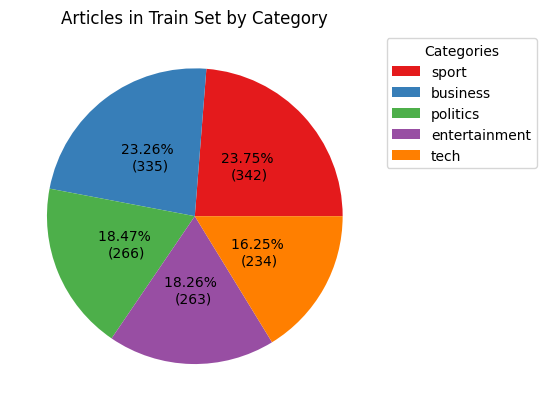

In [ ]:
# Taking a look at the number of articles for each topic

pie_data = data_train.drop_duplicates(["Text"], keep="first").Category.value_counts()


categories = list(pie_data.index)
color_map = plt.get_cmap("Set1")

palette = {cat: color_map(i) for i, cat in enumerate(categories)}

#https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}% \n({v})'.format(p=pct,v=val)
    return my_autopct

plt.pie(pie_data.values, colors=[palette[cat] for cat in pie_data.index], autopct=make_autopct(pie_data.values), pctdistance=0.5)

plt.legend(
    pie_data.index,
    title="Categories",
    loc="upper left",
    bbox_to_anchor=(1, 1)
)
plt.title("Articles in Train Set by Category")

There is an even spread in the number of articles for each topic. Note that even without this fact, we cannot adjust during an unsupervised approach since that takes the fact that there are categories into account. No action is needed when preparing for the model.

<H3> Length of Articles </H3>

In [ ]:
# Initial Tokenizer
tokenizer = CountVectorizer(stop_words="english").build_analyzer()
data_train["tokenized"] = data_train.Text.apply(tokenizer)
data_train["tokenized_length"] = data_train.tokenized.apply(len)

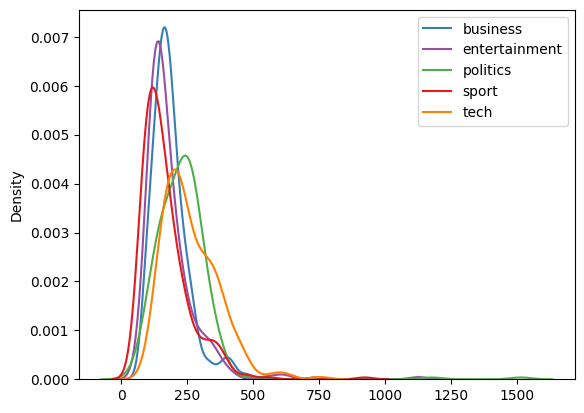

In [ ]:
# Looking at the length of the articles

doc_lengths_cat = data_train.groupby("Category").agg({"tokenized_length" : list}).reset_index()

len_data_cats = list(doc_lengths_cat.Category)
len_data_vals = list(doc_lengths_cat.tokenized_length)


for cat, vals in zip(len_data_cats, len_data_vals):
    sns.kdeplot(vals, label=cat, color=palette[cat], fill=False)

plt.legend(len_data_cats)

There are articles of various lengths. In order to adjust for that, we will need to normalize the document vectors. We can also adjust the weight of words to account for the number of words in the article.

<H3> Common Words </H3>

<H4> Accross Categories (Supervized Only) </H4>

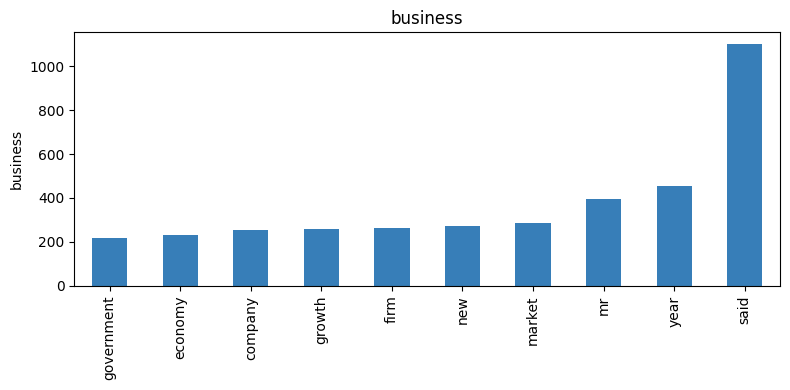

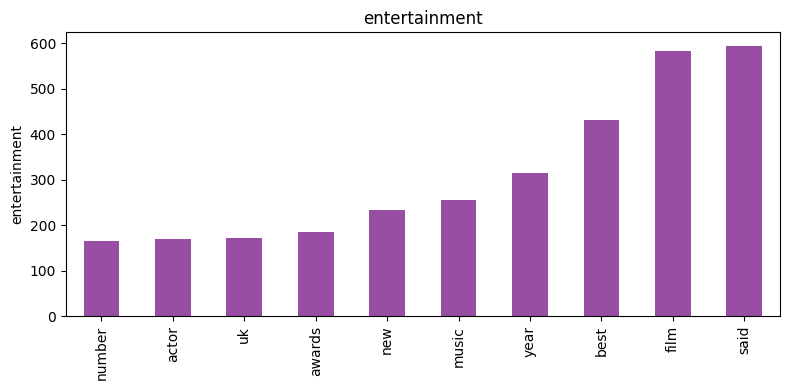

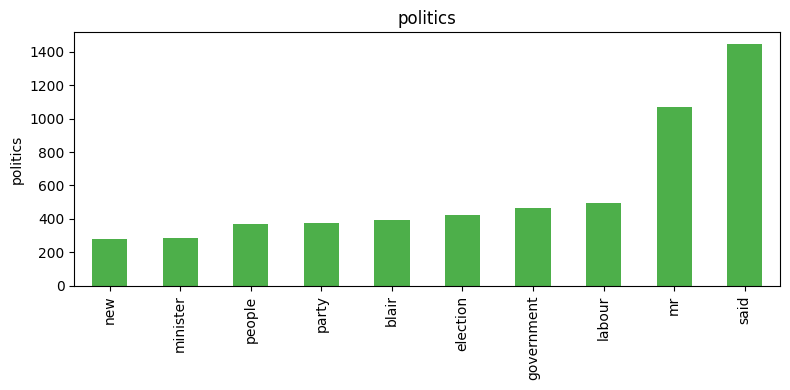

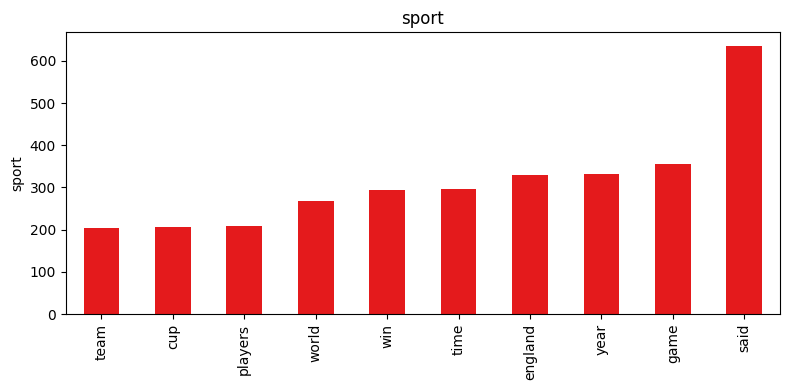

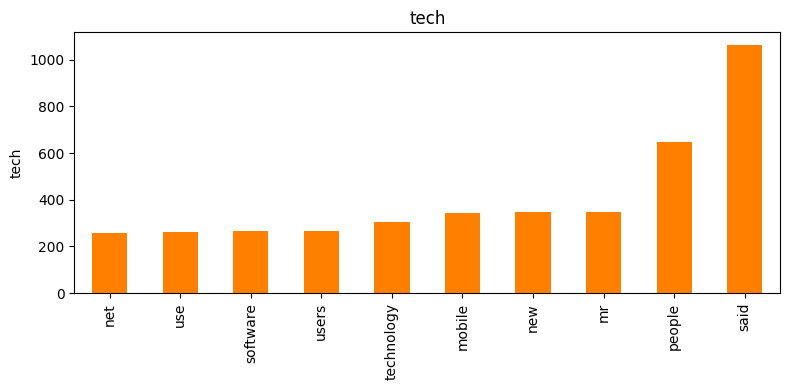

In [ ]:
# Common words accross Categories

data_train["tokenized"] = data_train.Text.apply(tokenizer)
categorized = data_train.groupby("Category")["tokenized"].sum().reset_index()
categorized["word_dict"] = categorized["tokenized"].apply(Counter)

cat_words = pd.DataFrame.from_records(list(categorized["word_dict"].apply(dict))).fillna(0).T
cat_words.columns = list(categorized["Category"])
cat_words = cat_words.astype(int)
    
cat_words_dict = {
    k: cat_words.sort_values(k).tail(10)[k].to_dict()
    for k in cat_words.columns
}

for k, d in cat_words_dict.items():
    pd.Series(d).plot(kind='bar', color=palette[k], figsize=(8,4), title=k)
    plt.ylabel(k)
    plt.tight_layout()
    plt.show()


<H4> In General (Supervised and Unsupervised) </H4>

In [ ]:
# In General

# dispersion score. min: 1/(number of categories), max : 1
def part_sum(l):
    tot = sum(l)
    summer = sum([(e/tot)**2 for e in l])
    return summer

cat_words["argument"] = cat_words.drop(["argument", "appear"], axis=1, errors="ignore").apply(part_sum, axis=1)
cat_words["appear"] = cat_words.drop(["argument", "appear"], axis=1, errors="ignore").apply(sum, axis=1)
cat_words.sort_values(["argument", "appear"], ascending=[True, False]).head(25)

,business,entertainment,politics,sport,tech,argument,appear
39,4,4,4,4,4,0.200000,20
enormous,4,4,4,4,4,0.200000,20
equally,3,3,3,3,3,0.200000,15
teeth,1,1,1,1,1,0.200000,5
unwilling,1,1,1,1,1,0.200000,5
ringing,1,1,1,1,1,0.200000,5
survive,1,1,1,1,1,0.200000,5
54,4,4,4,4,3,0.202216,19
factor,6,7,7,5,7,0.203125,32
little,30,30,33,38,41,0.203286,172


The above words have low dispersion scores, meaning they are very diverse in what category they represent, in supervised models, it may be worth removing them.

In [9]:
cat_words.sort_values(["argument", "appear"], ascending=[False, False]).head(15)

,business,entertainment,politics,sport,tech,argument,appear
tory,0,0,170,0,0,1.0,170
tories,0,0,158,0,0,1.0,158
lib,0,0,133,0,0,1.0,133
yukos,122,0,0,0,0,1.0,122
actress,0,116,0,0,0,1.0,116
ukip,0,0,101,0,0,1.0,101
festival,0,100,0,0,0,1.0,100
spam,0,0,0,0,99,1.0,99
roddick,0,0,0,97,0,1.0,97
mobiles,0,0,0,0,94,1.0,94


The above words are very topic specific, and make good indicators about what category the document belongs to.

In [10]:
cat_words.sort_values(["appear"], ascending=[False]).head(15)

,business,entertainment,politics,sport,tech,argument,appear
said,1100,594,1445,636,1064,0.221535,4839
mr,393,151,1073,8,349,0.372226,1974
year,456,315,175,331,251,0.218585,1528
new,273,234,280,202,349,0.206838,1338
people,120,127,372,58,647,0.337076,1324
time,115,136,139,296,196,0.227624,882
world,169,99,85,269,183,0.233690,805
uk,149,171,254,11,196,0.253287,781
government,215,30,464,3,40,0.466893,752
film,7,583,6,0,50,0.820659,646


The above are the most common words (CountVectorizer is a tokenizer which takes stop_words, already having removed "and" and other similar useless words.) This is the only section available to Unsupervised models, as it does not take category into account.

<H2>Plan of Action </H2>

-> Tokenize the words (Try different Tokenizers)

-> Take out numbers if the Tokenizer hasn't already.

-> Normalize based on the length of the document

-> Take out common words (For unsupervised: we can't use categories or "argument", only "appear")


Note: during unsupervised learning, we can't take out words that are even accross all categories, nor make sure the documents are balanced, since we do not have categories.

We should only use the training data when building the models, including the matrix shape. Otherwise, we will end up with entirely empty columns when training. We must make sure the test cases are vectorized to the same model as the training data, not the other way around.


<H2> Unsupervised NMF <H2>

<H3> Tokenizers </H3>

In [ ]:
import re
from nltk import WordPunctTokenizer, TreebankWordTokenizer, PorterStemmer


# Here we can add Tokenizers to try.
cv = CountVectorizer(stop_words="english")
tf = TfidfVectorizer(stop_words="english")
wp = WordPunctTokenizer()
tw = TreebankWordTokenizer()
ps = PorterStemmer()

def comb_to_stop(doc):
    return tokenizers["CountVectorizer"](" ".join(tokenizers["PorterStem"](doc))) 

tokenizers = {
    "CountVectorizer" : cv.build_analyzer(),
    "TfidfVectorizer" : tf.build_analyzer(),
    "NLTK_WordPunct" : wp.tokenize,
    "NLTK_Treebank" : tw.tokenize,
    "PorterStem" : lambda doc: [ps.stem(w) for w in re.findall(r"[A-Za-z]+", doc.lower())],
    "Combined" : comb_to_stop
} 

for k,v in tokenizers.items():
    print(v(data_train.Text[0]))

['worldcom', 'ex', 'boss', 'launches', 'defence', 'lawyers', 'defending', 'worldcom', 'chief', 'bernie', 'ebbers', 'battery', 'fraud', 'charges', 'called', 'company', 'whistleblower', 'witness', 'cynthia', 'cooper', 'worldcom', 'ex', 'head', 'internal', 'accounting', 'alerted', 'directors', 'irregular', 'accounting', 'practices', 'telecoms', 'giant', '2002', 'warnings', 'led', 'collapse', 'firm', 'following', 'discovery', '11bn', '7bn', 'accounting', 'fraud', 'mr', 'ebbers', 'pleaded', 'guilty', 'charges', 'fraud', 'conspiracy', 'prosecution', 'lawyers', 'argued', 'mr', 'ebbers', 'orchestrated', 'series', 'accounting', 'tricks', 'worldcom', 'ordering', 'employees', 'hide', 'expenses', 'inflate', 'revenues', 'meet', 'wall', 'street', 'earnings', 'estimates', 'ms', 'cooper', 'runs', 'consulting', 'business', 'told', 'jury', 'new', 'york', 'wednesday', 'external', 'auditors', 'arthur', 'andersen', 'approved', 'worldcom', 'accounting', 'early', '2001', '2002', 'said', 'andersen', 'given', 

Different Tokenizers break up the articles into different ways. Some only take out the spaces and lowercases, while others, like PorterStem consider the meaning of the word. Multiple different Tokenizers were tried.

<H3> Model Functions </H3>

In [ ]:
# Splits a dataframe into a matrix and an index dictionary. useful for knowing how to turn new documents into vectors for the model
def split_into_matrix(df: pd.DataFrame):
    id_list = {x : y for x, y in zip(df.columns, range(len(df.columns)))}

    m = np.array(df)
    return id_list, m

# Turns a document into a vector dictionary.
def text_doc_into_word_dict(doc, length_exp=0.5, tokenizer="CountVectorizer"):
    if isinstance(tokenizer, str):
        tokenizer = tokenizers[tokenizer]
    tokenized = tokenizer(doc)
    denumeric = [t for t in tokenized if not any(ch.isdigit() for ch in t)]
    dictr = Counter(denumeric)
    doc_len = len(doc.split())
    scaled = {k: v / (doc_len ** length_exp) for k, v in dictr.items()}
    total = sum(scaled.values())
    return {k: v / total for k, v in scaled.items()} if total > 0 else scaled

# Creates the matrix and the word-index dictionary.
def matrix_from_train_data_unsupervised(
        train_data_texts, 
        word_thresh_min=1, 
        word_thresh_max=5000, # Number of documents a word appears in.
        ng_word_thresh=0, # Number of times the word appears in all the data. 
        text_to_dict_func=text_doc_into_word_dict):
    
    
    d = pd.DataFrame.from_records(train_data_texts.apply(text_to_dict_func)).fillna(0).drop_duplicates(keep="first")
    mask_app = d.apply(np.count_nonzero, axis=0)
    mask = (mask_app > word_thresh_min) & (mask_app < word_thresh_max)
    words = d.columns[mask].tolist()
    
    if (ng_word_thresh >= 1) and (cat_words is not None): # UNSUPERVISED
        ng_words = list(cat_words[cat_words["appear"] >= ng_word_thresh].index)
        words = [w for w in words if w not in ng_words]
    d = d[words].copy()

    word_dict, model_matrix = split_into_matrix(d)

    return word_dict, model_matrix

# Creates the NMF model.
def factor_model(m_matrix, sparsing = True, **kwargs):
    nmf_dict = {"n_components" : 5, "init" : 'random', "random_state" : 42, "max_iter" : 200} | kwargs
    nmf = NMF(**nmf_dict)

    W = None
    if not sparsing :
        W = nmf.fit_transform(m_matrix)
    else :
        W = nmf.fit_transform(csr_matrix(m_matrix).astype('float64'))

    H = nmf.components_

    return nmf, W, H

# Turns the test data into vectors that can be then be used in the model
def text_to_vector(doc, wd, length_exp=0):
    vec = np.zeros(len(wd), dtype=np.float64)
    word_counts = text_doc_into_word_dict(doc, length_exp=length_exp)
    for k, v in word_counts.items():
        idx = wd.get(k)
        if idx is not None:
            vec[idx] = v
    return vec

def predict_single_document(doc: str, wd: dict, model: NMF, length_exp=0):
    wd_array = text_to_vector(doc, wd, length_exp=length_exp)
    transformed = model.transform(wd_array.reshape(1, -1)) 
    return np.argmax(transformed, axis=1)[0]

def predict_multi_document(docs, wd: dict, model: NMF, length_exp=0):
    wd_arrays = docs.apply(lambda x : text_to_vector(x, wd, length_exp=length_exp) )
    nm = np.array(list(np.array(wd_arrays)))
    transformed = model.transform(nm) 
    return np.argmax(transformed, axis=1)

# Tests the predicted topics found through unsupervised learning to associate them to the supervised topics.
def create_category_association(ytdf, yp):
    asc_dict = {}
    for x in set(yp):
        l = [ytdf[k] for k in range(len(yp)) if yp[k] == x]
        asc_dict[x] = str(Counter(l).most_common()[0][0])
    return asc_dict


In the above, alot of the PoA was put into place. Taking out numbers and normalizing based on the length of the article (generally to an exponent of 0.5) were done in text_doc_into_word_dict, while selecting words to ignore happens in matrix_from_train_data_unsupervised.

<H3> Full Model </H3>

In [ ]:
# Creates and tests a model
def full_model(X_train, X_test, y_test, doc_len_exp = 0, word_thresh_min=1, ng_word_thresh=0, word_thresh_max=5000, tokenizer="CountVectorizer", **kwargs):
    wd, mm = matrix_from_train_data_unsupervised(
        X_train,
        word_thresh_min=word_thresh_min,
        word_thresh_max=word_thresh_max,
        ng_word_thresh=ng_word_thresh,
        text_to_dict_func=lambda x : text_doc_into_word_dict(x, doc_len_exp, tokenizer=tokenizer)
    )
    
    model, W, H = factor_model(mm, **kwargs)

    #train_y_true = list(data_train.Category)
    test_y_pred = predict_multi_document(X_test, wd, model)#, length_exp=doc_len_exp

    #cluster , acc, to_dict = create_category_association2(train_y_true, train_y_pred)
    to_dict = create_category_association(y_test, test_y_pred)

    return model, to_dict, y_test, [to_dict[v] for v in test_y_pred]

<H3> Grid Searching Through Parameters </H3>

In [14]:
# FULL SET SKIPPED FOR TIME
# param_grid = {
#     "tokenizer": ["CountVectorizer", "NLTK_WordPunct", "PorterStem"],
#     "n_components": [5, 6],
#     "beta_loss": ["kullback-leibler", "frobenius"],
#     "solver": ["mu"],
#     "doc_len_exp": [0, 0.5, 1],
#     "word_thresh_min": [0, 1],
#     "ng_word_thresh" : [5000, 1000]
# }

param_grid = {
    "tokenizer": ["CountVectorizer", "NLTK_WordPunct", "PorterStem"],
    "n_components": [5, 6],
    "beta_loss": ["kullback-leibler"],
    "solver": ["mu"],
    "doc_len_exp": [0.5, 1],
    "word_thresh_min": [0, 1],
}

best_params = None
best_acc = -1
records = []

for params in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), params))

    model, mapping, y_true, y_pred = full_model(
        data_train.Text,
        data_train.Text,
        data_train.Category,
        **params,
    )

    acc = accuracy_score(y_true, y_pred)

    if acc > best_acc:
        best_acc = acc
        best_params = params

    records.append(params | {"Accuracy" : acc})


print("BEST:", best_params, best_acc)
pd.DataFrame.from_records(records)


BEST: {'tokenizer': 'CountVectorizer', 'n_components': 5, 'beta_loss': 'kullback-leibler', 'solver': 'mu', 'doc_len_exp': 0.5, 'word_thresh_min': 1} 0.9550335570469799


,tokenizer,n_components,beta_loss,solver,doc_len_exp,word_thresh_min,Accuracy
0,CountVectorizer,5,kullback-leibler,mu,0.5,0,0.907383
1,CountVectorizer,5,kullback-leibler,mu,0.5,1,0.955034
2,CountVectorizer,5,kullback-leibler,mu,1.0,0,0.907383
3,CountVectorizer,5,kullback-leibler,mu,1.0,1,0.955034
4,CountVectorizer,6,kullback-leibler,mu,0.5,0,0.783221
5,CountVectorizer,6,kullback-leibler,mu,0.5,1,0.777181
6,CountVectorizer,6,kullback-leibler,mu,1.0,0,0.783221
7,CountVectorizer,6,kullback-leibler,mu,1.0,1,0.777181
8,NLTK_WordPunct,5,kullback-leibler,mu,0.5,0,0.918792
9,NLTK_WordPunct,5,kullback-leibler,mu,0.5,1,0.718792


<H3> Best Model </H3>

In [15]:
best_wd, best_model_matrix = matrix_from_train_data_unsupervised(
        data_train.Text,
        word_thresh_min=1,
        word_thresh_max=5000,
        ng_word_thresh=0,
        text_to_dict_func=lambda x : text_doc_into_word_dict(x, 0.5, tokenizer=tokenizer)
    )
best_model, W, H = factor_model(best_model_matrix, n_components= 5, beta_loss= 'kullback-leibler', solver= 'mu')

test_y_pred_num = predict_multi_document(data_train.Text, best_wd, best_model)
to_dict = create_category_association(data_train.Category, test_y_pred_num)
test_y_pred = [to_dict[v] for v in test_y_pred_num]
print(accuracy_score(data_train.Category, test_y_pred))

0.9550335570469799


<H2> Supervised Alternatives </H2>

<H3> Train Test Split </H3>

In [39]:
from sklearn.model_selection import train_test_split

X_train_sub, X_test, y_train, y_test = train_test_split(data_train.Text, data_train.Category, train_size=0.75, random_state=0)

For supervised learning and hyperparameter optimization, we need to train-test split the data.

<H3> Word Dictionary </H3>

In [40]:
all_words = list(cat_words.index)

vocab_unpruned = sorted(all_words)
word2index_unpruned = {word: i for i, word in enumerate(vocab_unpruned)}

def text_doc_into_spec_vector(doc, word2index, length_exp, tokenizer="CountVectorizer"):
    if isinstance(tokenizer, str):
        tokenizer = tokenizers[tokenizer]
    tokenized = tokenizer(doc)
    denumeric = [t for t in tokenized if not any(ch.isdigit() for ch in t)]
    dictr = Counter(denumeric)
    doc_len = len(doc.split())
    scaled = {k: v / (doc_len ** length_exp) for k, v in dictr.items()}
    total = sum(scaled.values())
    inds = {word2index[k]: v / total for k, v in scaled.items() if k in word2index} if total > 0 else scaled
    vec = np.zeros(len(word2index))
    for i, j in inds.items():
        vec[i] = j
    return vec
    
X_train_unpruned = np.array(list(X_train_sub.apply(lambda x: text_doc_into_spec_vector(x, word2index_unpruned, 0.5))))
column_sums = X_train_unpruned.sum(axis=0)
keep_mask = column_sums > 0

X_train = X_train_unpruned[:, keep_mask]
vocab = [word for word, keep in zip(vocab_unpruned, keep_mask) if keep]
word2index = {word: i for i, word in enumerate(vocab)}

The above is used to create a consistent vocabulary, ensuring that the test cases can be easily transformed into vectors.

<H3> PCA <H3>

In [41]:
# Transformations

from sklearn.decomposition import PCA

pca_pre = PCA(n_components=len(X_train))
X_train_pca = pca_pre.fit_transform(X_train)

def test_docs_transform(docs, pca):
    return pca.transform( np.array(list(docs.apply(lambda x: text_doc_into_spec_vector(x, word2index, 0.5)))) )

Transformations applied to the data here, such as PCA, must be kept securely to be applied to the test cases. 

 0.9 Threshold Reached at 675 Dimensions
 0.95 Threshold Reached at 818 Dimensions


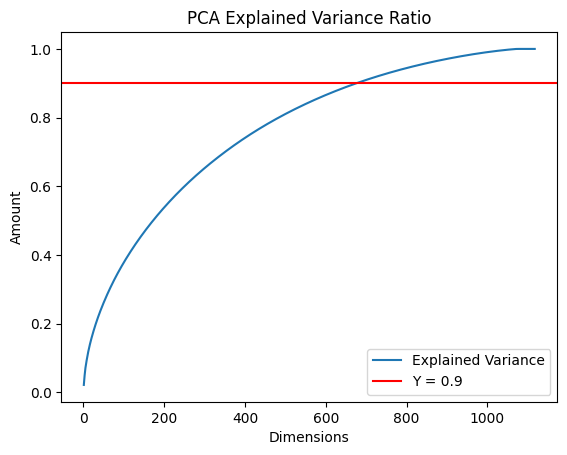

In [42]:
plt.plot(range(1,len(X_train)+1),pca_pre.explained_variance_ratio_.cumsum()) 
plt.title("PCA Explained Variance Ratio")
plt.xlabel("Dimensions")
plt.ylabel("Amount")
thresh = plt.axhline(y=0.9, color="r")
plt.legend(handles=[plt.gca().lines[0], thresh], labels=['Explained Variance', 'Y = 0.9'])
print(f" 0.9 Threshold Reached at {sum(pca_pre.explained_variance_ratio_.cumsum() < 0.9)} Dimensions")
print(f" 0.95 Threshold Reached at {sum(pca_pre.explained_variance_ratio_.cumsum() < 0.95)} Dimensions")

pca = PCA(n_components=len(X_train)) # Can change dimensions here
X_train_pca = pca.fit_transform(X_train)

<H3> Logistic Regression </H3>

In [43]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train_pca, y_train)

accuracy_score(y_test, clf.predict(test_docs_transform(X_test, pca)) )

0.4932975871313673

<H3> Ada Boost Classifier </H3>

In [44]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ens = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=16), n_estimators=100).fit(X_train_pca, y_train)

accuracy_score(y_test, ens.predict(test_docs_transform(X_test, pca)) )

0.8176943699731903

<H3> SVC </H3>

In [48]:
# Grid Searching

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

def search_exp_range(base=2, target_val=None, target_exp=2, prec=3):
    if target_val is not None:
        target_exp = np.log(target_val)/np.log(base)

    return np.arange((base**(target_exp-1)) , (base**(target_exp+1)) , (base**(target_exp-prec)))

def MultiGridSearch(X, y, base_estimator=SVC(kernel="sigmoid"), original_param_grid={}, base=2, prec=3, n_times = 2, **kwargs):
    grids = []
    grids.append(
        GridSearchCV(
            base_estimator,
            param_grid=original_param_grid,
            **kwargs
        ).fit(X,y)
    ) 
    for i in range(n_times):
        print(i)
        param_mids = grids[i].best_params_
        new_param_grid = {k : search_exp_range(base=base, prec=prec, target_val=v) for k,v in param_mids.items()}
        grids.append(
            GridSearchCV(
                base_estimator,
                param_grid=new_param_grid,
                **kwargs
            ).fit(X,y)
        )
    return grids

grids_rbf = MultiGridSearch(
    X_train_pca, 
    y_train, 
    original_param_grid={
        "gamma" : [16, 32, 64, 128],
        "C" : [0.4, 0.8, 1.6, 3.2]
    }
)

grids_rbf[0].best_params_

0
1


{'C': 1.6, 'gamma': 64}

In [64]:
svm_1 = SVC(C=1.6, kernel="sigmoid",  gamma=64)
svm_1.fit(X_train_pca, y_train)

accuracy_score(y_test, svm_1.predict(test_docs_transform(X_test, pca)))  

0.9758713136729222

After all the models that I tried, the best is the sigmoid SVC, parameters above.

<H3> Final Supervised Model </H3>

In [62]:
# Final Model

X_train_unpruned_fin = np.array(list(data_train.Text.apply(lambda x: text_doc_into_spec_vector(x, word2index_unpruned, 0.5))))
column_sums_fin = X_train_unpruned_fin.sum(axis=0)
keep_mask_fin = column_sums_fin > 0

X_train_fin = X_train_unpruned_fin[:, keep_mask_fin]
vocab_fin = [word for word, keep in zip(vocab_unpruned, keep_mask_fin) if keep]
word2index_fin = {word: i for i, word in enumerate(vocab_fin)}

pca_fin = PCA(n_components=len(X_train_fin))
X_train_pca_fin = pca_fin.fit_transform(X_train_fin)

svm_fin = SVC(C=0.8, kernel="sigmoid",  gamma=64)
svm_fin.fit(X_train_pca_fin, data_train.Category)

def test_docs_transform_fin(docs, pca):
    return pca.transform( np.array(list(docs.apply(lambda x: text_doc_into_spec_vector(x, word2index_fin, 0.5)))) )

accuracy_score(data_train.Category, svm_fin.predict(test_docs_transform_fin(data_train.Text, pca_fin))) # Not really important here, Since it is on itself. 


0.9939597315436242

In [63]:
# Final Predictions:
svm_fin.predict(test_docs_transform_fin(data_test.Text, pca_fin))


array(['sport', 'tech', 'sport', 'business', 'sport', 'sport', 'politics',
       'politics', 'entertainment', 'business', 'business', 'tech',
       'politics', 'tech', 'entertainment', 'sport', 'politics', 'tech',
       'entertainment', 'entertainment', 'business', 'politics', 'sport',
       'business', 'politics', 'sport', 'business', 'sport', 'sport',
       'business', 'politics', 'tech', 'business', 'business', 'sport',
       'sport', 'sport', 'business', 'entertainment', 'entertainment',
       'tech', 'politics', 'entertainment', 'tech', 'sport', 'tech',
       'entertainment', 'business', 'politics', 'business', 'politics',
       'business', 'business', 'business', 'tech', 'politics', 'tech',
       'entertainment', 'sport', 'tech', 'sport', 'entertainment', 'tech',
       'politics', 'entertainment', 'entertainment', 'sport', 'tech',
       'sport', 'sport', 'tech', 'sport', 'business', 'politics', 'tech',
       'sport', 'tech', 'tech', 'tech', 'entertainment', 'politics

<H2> Conclusion </H2>

<H3> Final Scores <H3>



Unsupervised NMF : Accuracy about 0.955 on the set the word matrix was made from.

Supervised SVC : Accuracy about 0.975 on a 25% test set.

The supervised model uses less of the data, and has less of a chance to overfit because the test cases are different than the training cases.

<H3> References </H3>

Daniel Jurafsky and James H. Martin. 2025. Speech and Language Processing: An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition with Language Models, 3rd edition. Online manuscript released August 24, 2025. Chapter 2 https://web.stanford.edu/~jurafsky/slp3/2.pdf.

Gillis, N. 2011. Nonnegative matrix factorization: complexity, algorithms and applications. https://www.researchgate.net/publication/347745850_Nonnegative_Matrix_Factorization

Siebers Philipp, et al. 2022. A survey of text representation methods and their genealogy. https://doi.org/10.1109/access.2022.3205719. https://arxiv.org/abs/2211.14591

Singhal, Amit, et al. 2017. Pivoted document length normalization. ACM SIGIR Forum, vol. 51, no. 2, 2 Aug. 2017, pp. 176–184, https://doi.org/10.1145/3130348.3130365. https://sigir.org/wp-content/uploads/2017/06/p176.pdf

https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction